# 딥러닝 자연어 처리의 일반적인 프로세스

> 3.2.2 장에 해당하는 코드

## 토큰화

In [1]:
# 코드 3-19

eng_sentence = "the quick brown fox jumps over the lazy dog"

## 방법 1. SpaCy
# pip install spacy
# python -m spacy download en
import spacy
spacy_en = spacy.load('en')

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

print(tokenize_en(eng_sentence))

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


In [2]:
# 코드 3-19

## 방법 2. nltk
# conda install nltk
from nltk.tokenize import word_tokenize

print(word_tokenize(eng_sentence))

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


In [3]:
# 코드 3-19

## 방법 3. split

print(eng_sentence.split())

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


In [4]:
# 코드 3-21

from konlpy.tag import Mecab

kor_sentence = "오늘 날씨 좋다"
tokenizer = Mecab()
# morphs 함수로 형태소 분석을 할 수 있다.
print(tokenizer.morphs(kor_sentence))

# pos 함수로 품사 태깅을 한다.
tokenized_sent = tokenizer.pos(kor_sentence)
print(tokenized_sent)
# 영어로 된 품사정보를 한글로 전환
print([(k, tokenizer.tagset.get(v)) for k, v in tokenized_sent])

['오늘', '날씨', '좋', '다']
[('오늘', 'MAG'), ('날씨', 'NNG'), ('좋', 'VA'), ('다', 'EC')]
[('오늘', '일반 부사'), ('날씨', '일반 명사'), ('좋', '형용사'), ('다', '연결 어미')]


## 단어장

### 네이버 댓글 데이터의 토큰화

In [5]:
# 코드 3-22

from konlpy.tag import Mecab
tokenizer = Mecab()
# 필자의 데이터 저장위치: ./data/nsmc/
# 데이터 불러오기: 첫 20 문장만 선택
with open("./data/nsmc/ratings.txt") as file:
    # 행단위로 데이터를 분리한다. 첫 열은 댓글에 해당하는 id 가 있음으로 제외한다.
    raw_data = file.read().splitlines()[1:]
    # 텍스트 데이터와 라벨을 분리한다.
    data = [line.split("\t")[1:] for line in raw_data]
    # 토큰화를 진행한다.
    data = [(tokenizer.morphs(sent), int(label)) for (sent, label) in data]
    
# 10개의 긍정 댓글과 10 개의 부정적인 댓글을 샘플링 한다.
sample_data = data[4:14] + data[-10:]
print(sample_data[0])

(['안개', '자욱', '한', '밤하늘', '에', '떠', '있', '는', '초승달', '같', '은', '영화', '.'], 1)


### 단어장 생성

In [6]:
# 코드 3-23

def build_vocab(data):
    # flatten 함수는 list 안의 list 를 하나의 리스트로 풀어준다
    flatten = lambda d: [token for sent in d for token in sent]
    vocab = {}
    # unkown 과 pad 토큰을 설정한다
    vocab['<unk>'] = 0
    vocab['<pad>'] = 1
    # 단어장을 생성한다.
    for token in flatten(list(zip(*data))[0]):
        if vocab.get(token) is None:
            vocab.setdefault(token, len(vocab))
    return vocab

vocab = build_vocab(sample_data)

## 수치화

In [7]:
# 코드 3-24

def numericalize(sent, vocab):
    temp = []
    for token in sent:
        if vocab.get(token) is None:
            temp.append(vocab['<unk>'])
        else:
            temp.append(vocab.get(token))
    return temp

In [8]:
# 코드 3-24

numerical_data = [(numericalize(sent, vocab), label) \
                  for sent, label in sample_data]
print(numerical_data[0])

([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 1)


### Bag of words

In [9]:
# 코드 3-25

import torch
from collections import Counter

num_docs = len(numerical_data)
num_vocab = len(vocab)
term_matrix = torch.zeros(num_docs, num_vocab)

for i, (sent, label) in enumerate(numerical_data):
    tokens, cnts = zip(*list(Counter(sent).items()))
    term_matrix[i, torch.LongTensor(tokens)] = torch.FloatTensor(cnts)

In [10]:
# 코드 3-25

# 빈도 행렬 크기
print(term_matrix.size())
# 빈도 행렬에서 카운트가 0인 개수
print(term_matrix.eq(0).sum())

torch.Size([20, 157])
tensor(2917)


### Heaps' Law

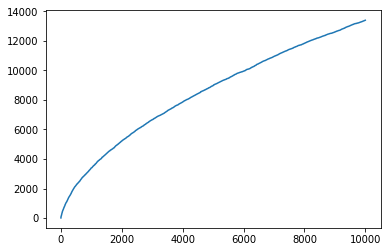

In [12]:
# 그림 3-35
%matplotlib inline
import matplotlib.pyplot as plt

global_unique = []
global_unique_cnt = []
for sent in data[:10000]:
    unique = set(sent[0])
    global_unique += list(unique)
    global_unique = list(set(global_unique))
    global_unique_cnt.append(len(global_unique))

fig, ax = plt.subplots(1, 1)
ax.plot(list(range(10000)), global_unique_cnt)
plt.show()

### Padding

In [13]:
# 코드 3-26

print("Before Length of Sentences: ")
print([len(sent) for sent, _ in numerical_data])
max_len = max([len(sent) for (sent, _) in numerical_data])
# 패딩과정
for sent, _ in numerical_data:
    if len(sent) < max_len:
        sent += [vocab['<pad>']] * (max_len - len(sent))
print("After Length of Sentences: ")
print([len(sent) for sent, _ in numerical_data])
print(numerical_data[0])

Before Length of Sentences: 
[13, 17, 6, 17, 1, 8, 38, 2, 6, 20, 19, 18, 3, 9, 11, 6, 5, 15, 15, 8]
After Length of Sentences: 
[38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38]
([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 1)


## TorchText

```
(torchenv) $ pip install torchtext
```

### 필드 정의

In [14]:
# 코드 3-27

from torchtext.data import Field
from konlpy.tag import Mecab

# 토큰화 함수로 MeCab 사용
tokenizer = Mecab()


# 필드 정의
TEXT = Field(sequential=True,
             use_vocab=True,
             tokenize=tokenizer.morphs,  
             lower=True, 
             batch_first=True)  
LABEL = Field(sequential=False,  
              use_vocab=False,   
              preprocessing = lambda x: int(x),  
              batch_first=True, 
              is_target=True)

# 각 댓글에 해당하는 id, 사용하지 않지만 기본필드로 정의 해준다.
ID = Field(sequential=False,  
           use_vocab=False,   
           is_target=False)

### 데이터셋 만들기

In [15]:
# 코드 3-28

from torchtext.data import TabularDataset

dataset = TabularDataset(path='./data/nsmc/ratings.txt', 
                         format='tsv', 
                         fields=[('id', ID), ('text', TEXT), ('label', LABEL)],
                         skip_header=True)

### 단어장 생성

In [16]:
# 코드 3-29

TEXT.build_vocab(dataset)
print('Total vocabulary: {}'.format(len(TEXT.vocab)))
print('Token for "<unk>": {}'.format(TEXT.vocab.stoi['<unk>']))
print('Token for "<pad>": {}'.format(TEXT.vocab.stoi['<pad>']))

Total vocabulary: 60825
Token for "<unk>": 0
Token for "<pad>": 1


### 데이터 로더 설정

In [17]:
# 코드 3-30

from torchtext.data import Iterator
device = "cuda" if torch.cuda.is_available() else "cpu"

data_loader = Iterator(dataset=dataset, 
                       batch_size=3,
                       device=device)

for batch in data_loader:
    break

# 필드에서 정의한 이름으로 호출 할 수 있다.
print(batch.text.size(), batch.label.size())
print(batch.text)

torch.Size([3, 12]) torch.Size([3])
tensor([[16861, 16855,    69, 16861, 16855,     2,    17,     1,     1,     1,
             1,     1],
        [   28,    10,  5451,     4,  1952,    22,    53,    41,    21,    21,
         14742, 12032],
        [ 6520,  2376,   365,    10,  1301,  3393,    13,  2394,     1,     1,
             1,     1]], device='cuda:0')
